# Run simulations

In [84]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import necessary libraryes
import joblib
import numpy as np
import pandas as pd
import plotnine as p9
import psutil
from src.population_density_networks import model

## Modeling Parameters

In [ ]:
# Fixed global parameters
N = 1000
K_CAP_MEAN = 50
K_CAP_SD = 20
RADIUS = 1.0

# Varying parameters
DENSITIES = np.logspace(-4, 4, 16, base=10)

# Simulation parameters
SIMULATION_ROUNDS = 2 * N * K_CAP_MEAN
SIMULATION_REPLICATES = 50
N_JOBS = psutil.cpu_count(logical=True) - 1

## Run Simulations

In [ ]:
 #####################
# Run simulations
#####################
# Generate all parameter combinations
param_combinations = [
    (density, replicate, N, K_CAP_MEAN, K_CAP_SD, RADIUS, SIMULATION_ROUNDS)
    for density in DENSITIES
    for replicate in range(SIMULATION_REPLICATES)
]

print(f"🚀 Running {len(param_combinations)} simulations in parallel...")

# Run simulations in parallel
parallel_jobs = min(N_JOBS, len(param_combinations))
results_list = joblib.Parallel(n_jobs=parallel_jobs, verbose=10)(
    joblib.delayed(model.run_single_simulation)(*params) for params in param_combinations
)

# Convert results to DataFrame
results = pd.DataFrame(results_list)

🚀 Running 800 simulations in parallel...


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   6 tasks      | elapsed:   39.4s
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done  35 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=13)]: Done  59 tasks      | elapsed:  3.3min
[Parallel(n_jobs=13)]: Done  72 tasks      | elapsed:  4.0min
[Parallel(n_jobs=13)]: Done  87 tasks      | elapsed:  4.7min
[Parallel(n_jobs=13)]: Done 102 tasks      | elapsed:  5.3min
[Parallel(n_jobs=13)]: Done 119 tasks      | elapsed:  6.6min
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:  7.3min
[Parallel(n_jobs=13)]: Done 155 tasks      | elapsed:  8.0min
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:  9.3min
[Parallel(n_jobs=13)]: Done 195 tasks      | elapsed: 10.0min
[Parallel(n_jobs=13)]: Done 216 tasks      | elapsed: 1

In [87]:
results

,n,k_cap_mean,k_cap_sd,radius,simulation_rounds,population_density,replicate,network_density,network_is_connected,network_num_components,network_largest_component_size,network_avg_shortest_path,network_diameter,network_clustering_coef,network_modularity,network_assortativity
0,1000,50,20,1.0,100000,0.0001,0,0.043628,True,1,1000,2.279756,4,0.168409,0.373330,0.035425
1,1000,50,20,1.0,100000,0.0001,1,0.044368,True,1,1000,2.271670,4,0.173387,0.387083,0.046550
2,1000,50,20,1.0,100000,0.0001,2,0.043630,True,1,1000,2.279852,4,0.169943,0.401181,0.045926
3,1000,50,20,1.0,100000,0.0001,3,0.044126,True,1,1000,2.275702,4,0.170694,0.372462,0.045706
4,1000,50,20,1.0,100000,0.0001,4,0.043445,True,1,1000,2.288084,4,0.167483,0.377691,0.065795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1000,50,20,1.0,100000,10000.0000,45,0.048298,True,1,1000,2.081658,3,0.058086,0.137450,0.122488
796,1000,50,20,1.0,100000,10000.0000,46,0.048621,True,1,1000,2.076350,3,0.059262,0.131371,0.104320
797,1000,50,20,1.0,100000,10000.0000,47,0.048184,True,1,1000,2.081309,3,0.058544,0.137219,0.100682
798,1000,50,20,1.0,100000,10000.0000,48,0.048913,True,1,1000,2.075083,3,0.059402,0.128710,0.103311


## Preliminary analysis of results
More in-depth plotting will be done in R.

In [88]:
#####################
# Calculate averages + simulation ranges for all network metrics
#####################
# Get all network metric columns (exclude boolean columns from quantile calculations)
network_metric_cols = [
    'network_density',
    'network_num_components', 'network_largest_component_size', 
    'network_avg_shortest_path', 'network_diameter',
    'network_clustering_coef', 'network_modularity',
    'network_assortativity'
]

# Define aggregation functions
def quantile_lower(x):
    return x.quantile(0.1)

def quantile_upper(x):
    return x.quantile(0.9)

# Create aggregation dictionary for all numeric network columns
agg_dict = {
    col: ['mean', 'std', quantile_lower, quantile_upper]
    for col in network_metric_cols
}

# Calculate statistics
summarized_stats = (
    results[['population_density'] + network_metric_cols]
    .groupby('population_density')
    .agg(agg_dict)
    .reset_index()
)

# Flatten multi-index columns
# The columns will be: population_density, then for each metric: mean, std, quantile_lower, quantile_upper
flat_cols = ['population_density']
for col in network_metric_cols:
    flat_cols.extend([f'{col}_mean', f'{col}_std', f'{col}_quantile_lower', f'{col}_quantile_upper'])
summarized_stats.columns = flat_cols

summarized_stats



,population_density,network_density_mean,network_density_std,network_density_quantile_lower,network_density_quantile_upper,network_num_components_mean,network_num_components_std,network_num_components_quantile_lower,network_num_components_quantile_upper,network_largest_component_size_mean,...,network_clustering_coef_quantile_lower,network_clustering_coef_quantile_upper,network_modularity_mean,network_modularity_std,network_modularity_quantile_lower,network_modularity_quantile_upper,network_assortativity_mean,network_assortativity_std,network_assortativity_quantile_lower,network_assortativity_quantile_upper
0,0.0001,0.043783,0.000454,0.043112,0.044343,1.0,0.0,1.0,1.0,1000.0,...,0.166776,0.172649,0.374457,0.014514,0.354149,0.390166,0.046727,0.010152,0.033889,0.058950
1,0.0003,0.043945,0.000527,0.043389,0.044569,1.0,0.0,1.0,1.0,1000.0,...,0.165414,0.173149,0.370652,0.016830,0.345986,0.389532,0.047594,0.008417,0.038781,0.057880
2,0.0012,0.044203,0.000579,0.043513,0.045049,1.0,0.0,1.0,1.0,1000.0,...,0.164256,0.171715,0.372109,0.015978,0.351319,0.387901,0.048464,0.008204,0.039039,0.058586
3,0.0040,0.044634,0.000529,0.043924,0.045280,1.0,0.0,1.0,1.0,1000.0,...,0.162973,0.169681,0.368914,0.017677,0.344874,0.386632,0.051809,0.008070,0.042457,0.060582
4,0.0136,0.045315,0.000618,0.044588,0.045925,1.0,0.0,1.0,1.0,1000.0,...,0.160223,0.166223,0.365018,0.016049,0.345147,0.383989,0.058170,0.010068,0.046196,0.071988
5,0.0464,0.045930,0.000530,0.045228,0.046560,1.0,0.0,1.0,1.0,1000.0,...,0.153789,0.161370,0.357191,0.017470,0.335927,0.377600,0.067363,0.010049,0.056466,0.080203
6,0.1585,0.046576,0.000487,0.046058,0.047251,1.0,0.0,1.0,1.0,1000.0,...,0.145420,0.153271,0.353719,0.017666,0.328968,0.375810,0.078042,0.009337,0.067565,0.090212
7,0.5412,0.047323,0.000572,0.046536,0.048079,1.0,0.0,1.0,1.0,1000.0,...,0.133304,0.139596,0.339288,0.015830,0.319613,0.355525,0.081159,0.009293,0.071639,0.091750
8,1.8478,0.047810,0.000574,0.047172,0.048393,1.0,0.0,1.0,1.0,1000.0,...,0.115306,0.121214,0.311124,0.014890,0.289348,0.326583,0.084565,0.012300,0.069221,0.098751
9,6.3096,0.048131,0.000582,0.047440,0.048875,1.0,0.0,1.0,1.0,1000.0,...,0.096012,0.099807,0.278200,0.015157,0.257490,0.296980,0.084707,0.012436,0.066994,0.098819


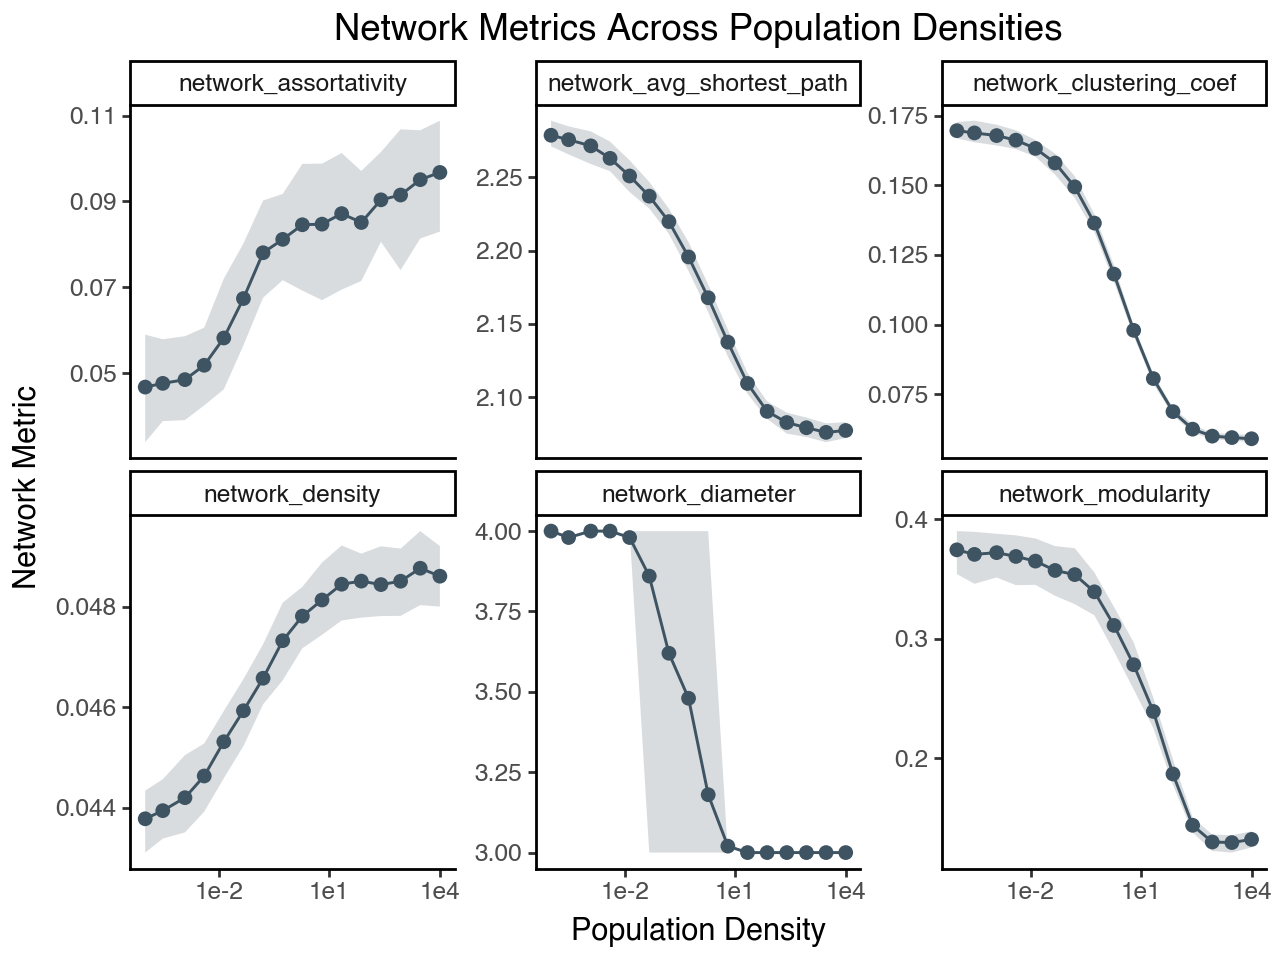

In [89]:
#####################
# Plot
#####################
from plotnine import (
    ggplot, aes, geom_point, geom_line, geom_ribbon, facet_wrap, labs, scale_x_continuous, theme_classic
)
import pandas as pd

# Melt summarized_stats for facetting
metrics_long = pd.melt(
    summarized_stats,
    id_vars=['population_density'],
    value_vars=[
        'network_density_mean', 'network_num_components_mean', 'network_largest_component_size_mean',
        'network_avg_shortest_path_mean', 'network_diameter_mean',
        'network_clustering_coef_mean', 'network_modularity_mean', 'network_assortativity_mean'
    ],
    var_name='metric', value_name='dummy'  # We will overwrite this, just a trick for index expansion
)

# Instead, we want: one row for each metric, with columns for mean, lower, upper
plot_df = pd.DataFrame()
for metric in [
        'network_density',
        'network_avg_shortest_path', 'network_diameter',
        'network_clustering_coef', 'network_modularity', 'network_assortativity'
    ]:
    tmp = summarized_stats[['population_density',
                      f'{metric}_mean',
                      f'{metric}_quantile_lower',
                      f'{metric}_quantile_upper']].copy()
    tmp['metric'] = metric
    tmp = tmp.rename(columns={
        f'{metric}_mean': 'mean',
        f'{metric}_quantile_lower': 'lower',
        f'{metric}_quantile_upper': 'upper'
    })
    plot_df = pd.concat([plot_df, tmp], ignore_index=True)

# Plot
graph_color = '#3f5463'
p = (
    ggplot(plot_df, aes(x='population_density', y='mean'))
    + geom_ribbon(aes(ymin='lower', ymax='upper'), alpha=0.2, fill=graph_color)
    + geom_line(size=0.6, color=graph_color)
    + geom_point(stroke=0, size=3, color=graph_color)
    + scale_x_continuous(trans='log10')
    + facet_wrap('~metric', scales='free_y')
    + labs(
        x='Population Density',
        y='Network Metric',
        title='Network Metrics Across Population Densities'
    )
    + theme_classic()
)
p
